In [74]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import time
import datascience as ds
np.random.seed(42)  
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,10)
plt.style.use('fivethirtyeight')

In [75]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from IPython.display import Image
import folium
from folium import IFrame
from folium.plugins import MarkerCluster
from folium import plugins
from datetime import datetime
import datetime as dt
import json
from scipy import stats

import os

## Data processing

In [76]:
pm = "https://raw.githubusercontent.com/Dr-Isam-ALJAWARNEH/ds-project-clustering-AQ-data/main/data/NYC_Pilot2_PM_Part1.csv?token=GHSAT0AAAAAACOQ2HNSGHS35TKOXLXRJWLKZRKCGOA"
pmdata = pd.read_csv('NYC_Pilot2_PM_Part1.csv') #contents of data)
pmdata.head()

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,bin17,bin18,bin19,bin20,bin21,bin22,bin23,temperature,humidity,pm25
0,NYCP2_CS01A,1631277304,40.847672,-73.869316,11,1,1,0,0,0,...,0,0,0,0,0,0,0,23.7,57.3,4.508813
1,NYCP2_CS01A,1631277308,40.847668,-73.869316,22,4,1,0,0,2,...,0,0,0,0,0,0,0,23.7,57.8,5.462420
2,NYCP2_CS01A,1631277313,40.847649,-73.869362,40,1,1,0,0,1,...,0,0,0,0,0,0,0,23.7,57.8,5.154881
3,NYCP2_CS01A,1631277318,40.847649,-73.869362,26,1,0,0,0,0,...,0,0,0,0,0,0,0,23.6,57.6,4.508813
4,NYCP2_CS01A,1631277323,40.847649,-73.869362,44,4,0,1,0,0,...,0,0,0,0,0,0,0,23.6,57.5,5.539503


In [77]:
pmdata = \
pmdata[(pmdata['latitude']!=0) & \
       (pmdata['longitude'] !=0)]

In [78]:
import  pygeohash as gh
geohash_precision=6

pmdata['geohash'] = pmdata.apply(lambda x:gh.encode(x.latitude, x.longitude, precision=geohash_precision), axis=1)

In [79]:
gdf_pm25=gpd.GeoDataFrame(pmdata, geometry=gpd.points_from_xy(pmdata.longitude, pmdata.latitude))
gdf_pm25=gdf_pm25.set_crs(epsg=4326) 

In [80]:
geojsonfile = "https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/nyc_polygon.geojson"
# Create a GeoDataFrame from the DataFrame by converting lat/lon to geometry
gdf_neighbourhoods = gpd.read_file(geojsonfile)
#gdf_neighbourhoods.crs

In [81]:
from geopandas.tools import sjoin
# Perform spatial join
joined_gdf_pm25 = sjoin(gdf_pm25, gdf_neighbourhoods, predicate="within")
joined_gdf_pm25.head()

,SensorID,time,latitude,longitude,bin0,bin1,bin2,bin3,bin4,bin5,...,temperature,humidity,pm25,geohash,geometry,index_right,neighborhood,boroughCode,borough,@id
0,NYCP2_CS01A,1631277304,40.847672,-73.869316,11,1,1,0,0,0,...,23.7,57.3,4.508813,dr72rh,POINT (-73.86932 40.84767),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
1,NYCP2_CS01A,1631277308,40.847668,-73.869316,22,4,1,0,0,2,...,23.7,57.8,5.462420,dr72rh,POINT (-73.86932 40.84767),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
2,NYCP2_CS01A,1631277313,40.847649,-73.869362,40,1,1,0,0,1,...,23.7,57.8,5.154881,dr72rh,POINT (-73.86936 40.84765),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
3,NYCP2_CS01A,1631277318,40.847649,-73.869362,26,1,0,0,0,0,...,23.6,57.6,4.508813,dr72rh,POINT (-73.86936 40.84765),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...
4,NYCP2_CS01A,1631277323,40.847649,-73.869362,44,4,0,1,0,0,...,23.6,57.5,5.539503,dr72rh,POINT (-73.86936 40.84765),38,Bronx Park,2,Bronx,http://nyc.pediacities.com/Resource/Neighborho...


In [82]:
type(joined_gdf_pm25)


geopandas.geodataframe.GeoDataFrame

In [83]:
joined_gdf_pm25.shape

(169995, 38)

In [84]:
n=len(pd.unique(joined_gdf_pm25['neighborhood']))
n

48

In [85]:
# Count NaN values for each feature
joined_gdf_pm25.isnull().sum()
joined_gdf_pm25 = joined_gdf_pm25.dropna()

In [86]:
# Select columns to copy
columns_to_copy = ['neighborhood','latitude', 'longitude', 'pm25']  # Replace with the names of the 
new_joined_gdf_pm25_2 = joined_gdf_pm25[columns_to_copy].copy()
type(new_joined_gdf_pm25_2)

pandas.core.frame.DataFrame

## Sampling Data

In [87]:
start=time.time()
sample_base= new_joined_gdf_pm25_2.sample(frac=0.4)
end=time.time()
print("excution time is:", end-start)
print('sample size:',sample_base.shape)
sample_base.head()

excution time is: 0.006938934326171875
sample size: (67998, 4)


,neighborhood,latitude,longitude,pm25
2671,Van Nest,40.844555,-73.871017,11.940597
105120,Mott Haven,40.807079,-73.923889,4.401811
1199,Randall's Island,40.798733,-73.918983,7.685065
9081,Bronx Park,40.846687,-73.869858,4.754259
124686,Longwood,40.818916,-73.898392,3.456080


In [88]:
sample2=sample_base['neighborhood'].value_counts()
sample2=sample2.reset_index()
sample2.colums=['neighborhood','count']
sample2['neighborhood']=sample2['neighborhood'].astype(str)
sample2.head()

C:\Users\Manar Anwer\AppData\Local\Temp\ipykernel_4456\2878840212.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  sample2.colums=['neighborhood','count']


,neighborhood,count
0,Longwood,17037
1,Mott Haven,15864
2,Bronx Park,15738
3,Hunts Point,7649
4,Van Nest,3013


In [89]:
original=joined_gdf_pm25['neighborhood'].value_counts()
original=original.reset_index()
original.colums=['neighborhood','count']
original['neighborhood']=original['neighborhood'].astype(str)
original.head()

C:\Users\Manar Anwer\AppData\Local\Temp\ipykernel_4456\141327972.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  original.colums=['neighborhood','count']


,neighborhood,count
0,Longwood,42523
1,Bronx Park,39495
2,Mott Haven,39287
3,Hunts Point,19280
4,Van Nest,7477


In [90]:
import folium
original["neighborhood"].astype(str)
geojsonfile=pm = "https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/nyc_polygon.geojson"
heatmap_scale=list()
threshold=[10,20,50,70,85,100]
for i in threshold:
    heatmap_scale.append(int(original['count'].max()*(i/100.0)))
map_original=folium.Map(location=[40.730610,-73.935242], zoom_start=10)
#Create choropleth map object with key on TOWNNAME
folium.Choropleth(geo_data = geojsonfile,#Assign geo_data to your geojson file
    name = "choropleth",
    data = original,#Assign dataset of interest
    columns = ["neighborhood","count"],#Assign columns in the dataset for plotting
    key_on = 'feature.properties.neighborhood',#Assign the key that geojson uses to connect with dataset
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.5,
    legend_name = 'neighborhood').add_to(map_original)

map_original


In [91]:
import folium
sample2["neighborhood"].astype(str)
geojsonfile=pm = "https://raw.githubusercontent.com/IsamAljawarneh/datasets/master/data/nyc_polygon.geojson"
heatmap_scale=list()
threshold=[10,20,50,70,85,100]
for i in threshold:
    heatmap_scale.append(int(sample2['count'].max()*(i/100.0)))
map_sample2=folium.Map(location=[40.730610,-73.935242], zoom_start=10)
#Create choropleth map object with key on TOWNNAME
folium.Choropleth(geo_data = geojsonfile,#Assign geo_data to your geojson file
    name = "choropleth",
    data = sample2,#Assign dataset of interest
    columns = ["neighborhood","count"],#Assign columns in the dataset for plotting
    key_on = 'feature.properties.neighborhood',#Assign the key that geojson uses to connect with dataset
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.5,
    legend_name = 'neighborhood').add_to(map_sample2)

map_sample2

from the above two maps we can see that our sample is actually representative of the population that we have. 

## Feature Scaling

In [92]:
from sklearn.preprocessing import StandardScaler
feature_columns = ["latitude", "longitude","pm25"]
# Scale these features
scaler = StandardScaler()
scaled_features=scaler.fit_transform(sample_base[feature_columns])
scaled_features= pd.DataFrame(scaled_features)
scaled_features

,0,1,2
0,1.067347,1.118438,4.258096
1,-1.105693,-1.614193,0.050713
2,-1.589635,-1.360632,1.883091
3,1.190971,1.178340,0.247413
4,-0.419327,-0.296408,-0.477098
...,...,...,...
67993,-0.571073,0.052975,1.215119
67994,-0.701133,-1.457642,1.831191
67995,1.152932,1.152705,-1.136748
67996,1.277020,1.226044,-1.085763


## K-means

## Silhouette Index for K-means


In [59]:
from sklearn.preprocessing import StandardScaler
feature_columns = ["latitude", "longitude","pm25"]
# Scale these features
scaler = StandardScaler()
scaled_features=scaler.fit_transform(new_joined_gdf_pm25_2[feature_columns])
scaled_features= pd.DataFrame(scaled_features)
scaled_features

,0,1,2
0,1.247148,1.200472,0.110286
1,1.246916,1.200472,0.641630
2,1.245812,1.198096,0.470271
3,1.245812,1.198096,0.110286
4,1.245812,1.198096,0.684580
...,...,...,...
169990,0.171082,-2.021579,-0.495496
169991,1.897260,-1.554217,-1.124756
169992,1.650854,-1.600705,-1.082711
169993,0.789537,2.270788,-0.471528


Training Time for k=2, Sample Ratio=0.1: 0.01 seconds
Training Time for k=2, Sample Ratio=0.2: 0.01 seconds
Training Time for k=2, Sample Ratio=0.3: 0.01 seconds
Training Time for k=2, Sample Ratio=0.6: 0.03 seconds
Training Time for k=3, Sample Ratio=0.1: 0.02 seconds
Training Time for k=3, Sample Ratio=0.2: 0.02 seconds
Training Time for k=3, Sample Ratio=0.3: 0.03 seconds
Training Time for k=3, Sample Ratio=0.6: 0.04 seconds
Training Time for k=4, Sample Ratio=0.1: 0.02 seconds
Training Time for k=4, Sample Ratio=0.2: 0.03 seconds
Training Time for k=4, Sample Ratio=0.3: 0.02 seconds
Training Time for k=4, Sample Ratio=0.6: 0.04 seconds
Training Time for k=5, Sample Ratio=0.1: 0.02 seconds
Training Time for k=5, Sample Ratio=0.2: 0.02 seconds
Training Time for k=5, Sample Ratio=0.3: 0.04 seconds
Training Time for k=5, Sample Ratio=0.6: 0.05 seconds
Training Time for k=8, Sample Ratio=0.1: 0.02 seconds
Training Time for k=8, Sample Ratio=0.2: 0.03 seconds
Training Time for k=8, Sampl

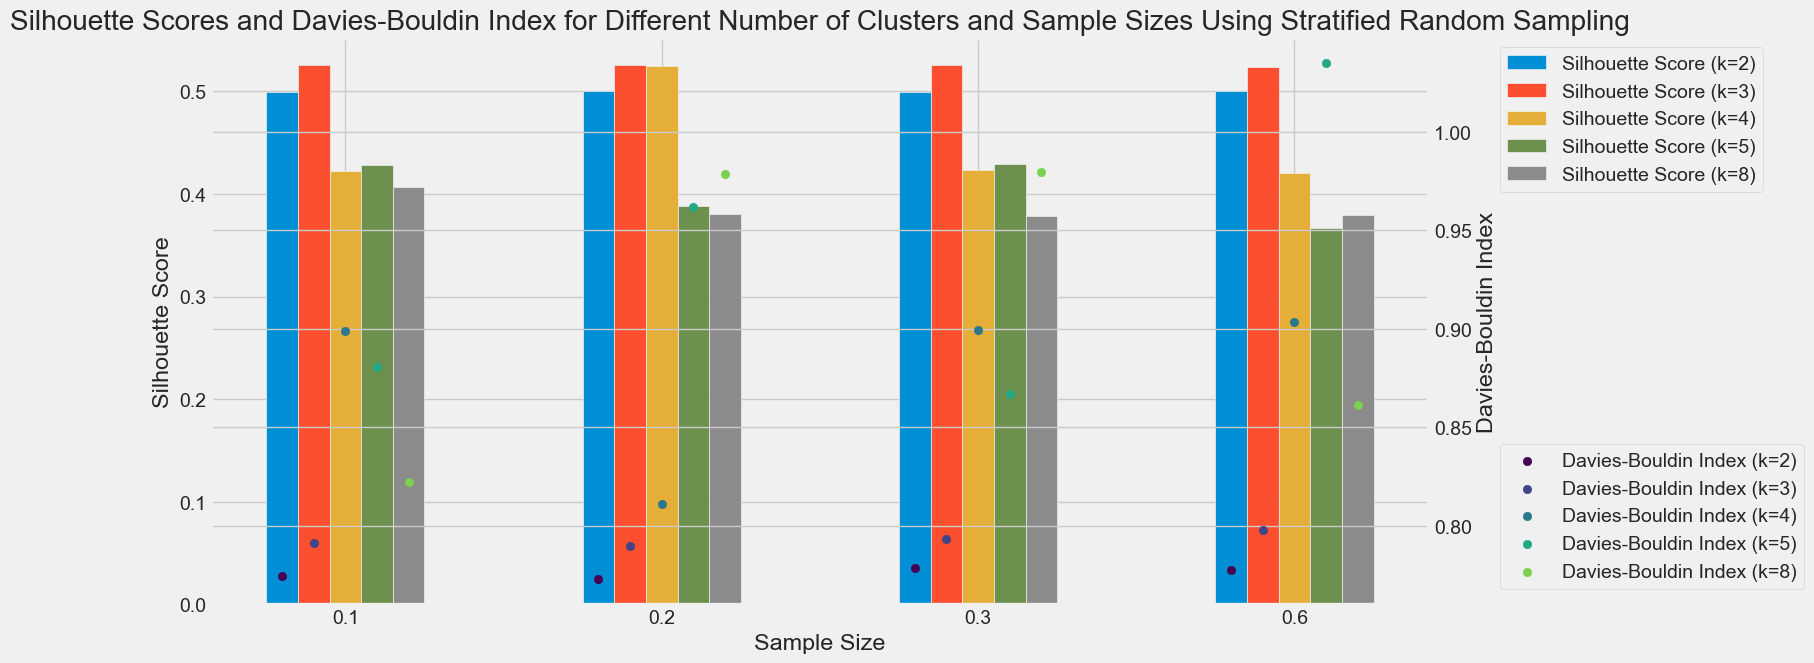

In [58]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time

# Assuming 'new_joined_gdf_pm25_2' is your DataFrame containing the data

# Define sample ratios and number of clusters (k) to test
sample_ratios = [0.1,0.2,0.3,0.6]
k_values = [2,3,4,5,8]  # Different number of clusters to test
silhouette_results = {k: [] for k in k_values}
davies_results = {k: [] for k in k_values}

# Iterate over each number of clusters
for k in k_values:
    # Create KMeans object inside the loop to avoid reuse
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Now iterate over each sample ratio
    for ratio in sample_ratios:
        # Sample a fraction of the data based on the ratio
        start_time = time.time()
        features_scaled_sample = scaled_features.sample(frac=ratio)
        
        # Check if we have enough samples to form the specified number of clusters          
        labels = kmeans.fit_predict(features_scaled_sample)
        end_time = time.time()
        training_time = end_time - start_time

        
        silhouette_avg = silhouette_score(features_scaled_sample, labels)
        davies_avg = davies_bouldin_score(features_scaled_sample, labels)
        silhouette_results[k].append(silhouette_avg)
        davies_results[k].append(davies_avg)

                # Print training time for each case
        print(f"Training Time for k={k}, Sample Ratio={ratio}: {training_time:.2f} seconds")

# Plotting the results
fig, ax = plt.subplots(figsize=(14, 7))

# Create a bar chart with grouped bars for each sample ratio for silhouette scores
bar_width = 0.1
index = np.arange(len(sample_ratios))

for i, (k, scores) in enumerate(silhouette_results.items()):
    # Offset each k's bar by the width
    ax.bar(index + i * bar_width, scores, bar_width, label=f'Silhouette Score (k={k})')

# Plot Davies-Bouldin Index on secondary y-axis
# Plot Davies-Bouldin Index on secondary y-axis with different colors
ax2 = ax.twinx()
for i, (k, scores) in enumerate(davies_results.items()):
    ax2.scatter(index + i * bar_width, scores, marker='o', label=f'Davies-Bouldin Index (k={k})', color=plt.cm.viridis(i / len(k_values)))

ax.set_xlabel('Sample Size')
ax.set_ylabel('Silhouette Score')
ax2.set_ylabel('Davies-Bouldin Index')
ax.set_title('Silhouette Scores and Davies-Bouldin Index for Different Number of Clusters and Sample Sizes Using Stratified Random Sampling')
ax.set_xticks(index + bar_width * (len(k_values) - 1) / 2)
ax.set_xticklabels(sample_ratios)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(bbox_to_anchor=(1.05, 0.3), loc='upper left')

plt.show()


## DBSCAN

In [73]:
scaled_features

,0,1,2
0,1.247148,1.200472,0.110286
1,1.246916,1.200472,0.641630
2,1.245812,1.198096,0.470271
3,1.245812,1.198096,0.110286
4,1.245812,1.198096,0.684580
...,...,...,...
169990,0.171082,-2.021579,-0.495496
169991,1.897260,-1.554217,-1.124756
169992,1.650854,-1.600705,-1.082711
169993,0.789537,2.270788,-0.471528


## Silhouette Index for DBSCAN to fix eps


Training Time for epsilon=0.3, Sample Ratio=0.1: 0.33 seconds
Training Time for epsilon=0.3, Sample Ratio=0.2: 1.11 seconds
Training Time for epsilon=0.3, Sample Ratio=0.4: 3.59 seconds
Training Time for epsilon=0.3, Sample Ratio=0.6: 7.71 seconds
Training Time for epsilon=0.5, Sample Ratio=0.1: 0.62 seconds
Training Time for epsilon=0.5, Sample Ratio=0.2: 2.33 seconds
Training Time for epsilon=0.5, Sample Ratio=0.4: 8.02 seconds
Training Time for epsilon=0.5, Sample Ratio=0.6: 15.54 seconds
Training Time for epsilon=0.7, Sample Ratio=0.1: 0.96 seconds
Training Time for epsilon=0.7, Sample Ratio=0.2: 3.42 seconds
Training Time for epsilon=0.7, Sample Ratio=0.4: 12.81 seconds
Training Time for epsilon=0.7, Sample Ratio=0.6: 21.72 seconds
Training Time for epsilon=0.9, Sample Ratio=0.1: 1.16 seconds
Training Time for epsilon=0.9, Sample Ratio=0.2: 4.24 seconds
Training Time for epsilon=0.9, Sample Ratio=0.4: 12.88 seconds
Training Time for epsilon=0.9, Sample Ratio=0.6: 30.00 seconds


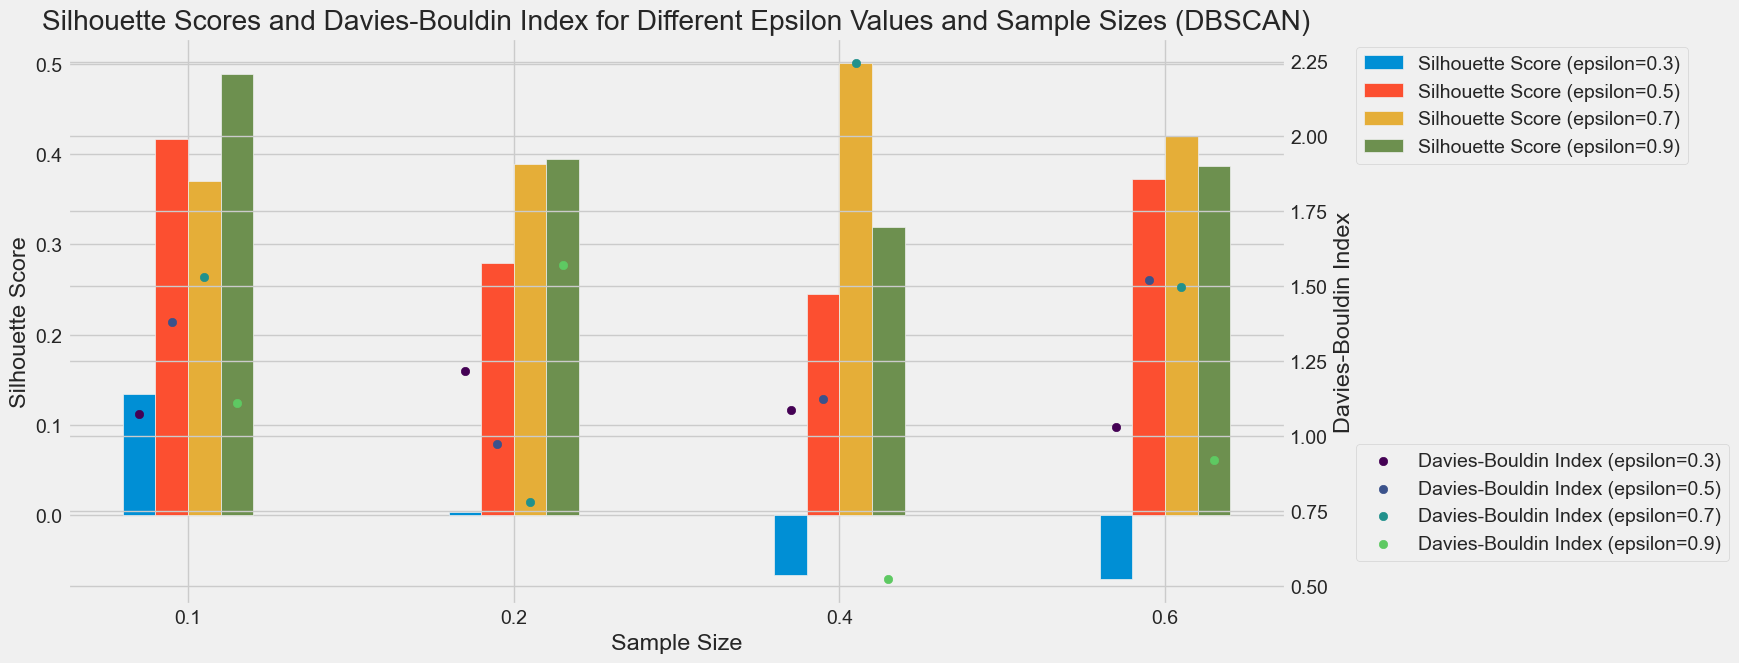

In [65]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time

# Assuming 'new_joined_gdf_pm25_2' is your DataFrame containing the data

# Define sample ratios and epsilon values to test
sample_ratios = [0.1, 0.2, 0.4, 0.6]
epsilon_values = [0.3, 0.5, 0.7, 0.9]  # Different epsilon values to test
silhouette_results = {epsilon: [] for epsilon in epsilon_values}
davies_results = {epsilon: [] for epsilon in epsilon_values}


# Iterate over each epsilon value
for epsilon in epsilon_values:
    # Now iterate over each sample ratio
    for ratio in sample_ratios:
        # Sample a fraction of the data based on the ratio
        start_time = time.time()
        features_scaled_sample = scaled_features.sample(frac=ratio)
        
        # Run DBSCAN clustering on the sampled and scaled features
        dbscan = DBSCAN(eps=epsilon, min_samples=10)
        labels = dbscan.fit_predict(features_scaled_sample)
        end_time = time.time()
        training_time = end_time - start_time

        # Calculate silhouette score and Davies-Bouldin Index only if there are more than 1 cluster
        if len(set(labels)) > 1:
            silhouette_avg = silhouette_score(features_scaled_sample, labels)
            davies_avg = davies_bouldin_score(features_scaled_sample, labels)
            silhouette_results[epsilon].append(silhouette_avg)
            davies_results[epsilon].append(davies_avg)
        else:
            silhouette_results[epsilon].append(None)  # Only noise points found
            davies_results[epsilon].append(None)

        # Print training time for each case
        print(f"Training Time for epsilon={epsilon}, Sample Ratio={ratio}: {training_time:.2f} seconds")

# Plotting the results
fig, ax = plt.subplots(figsize=(14, 7))

# Create a bar chart with grouped bars for each epsilon value for silhouette scores
bar_width = 0.1
index = np.arange(len(sample_ratios))

for i, (epsilon, scores) in enumerate(silhouette_results.items()):
    # Offset each epsilon's bar by the width
    ax.bar(index + i * bar_width, scores, bar_width, label=f'Silhouette Score (epsilon={epsilon})')

# Plot Davies-Bouldin Index on secondary y-axis
ax2 = ax.twinx()
for i, (epsilon, scores) in enumerate(davies_results.items()):
    ax2.scatter(index + i * bar_width, scores, marker='o', label=f'Davies-Bouldin Index (epsilon={epsilon})', color=plt.cm.viridis(i / len(epsilon_values)))

ax.set_xlabel('Sample Size')
ax.set_ylabel('Silhouette Score')
ax2.set_ylabel('Davies-Bouldin Index')
ax.set_title('Silhouette Scores and Davies-Bouldin Index for Different Epsilon Values and Sample Sizes (DBSCAN)')
ax.set_xticks(index + bar_width * (len(epsilon_values) - 1) / 2)
ax.set_xticklabels(sample_ratios)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(bbox_to_anchor=(1.05, 0.3), loc='upper left')

plt.show()

## Silhouette Index for DBSCAN to fix minSamples

Training Time for min_samples=2, Sample Ratio=0.1: 1.37 seconds
Training Time for min_samples=2, Sample Ratio=0.2: 4.36 seconds
Training Time for min_samples=2, Sample Ratio=0.4: 13.29 seconds
Training Time for min_samples=2, Sample Ratio=0.6: 28.26 seconds
Training Time for min_samples=5, Sample Ratio=0.1: 1.27 seconds
Training Time for min_samples=5, Sample Ratio=0.2: 4.31 seconds
Training Time for min_samples=5, Sample Ratio=0.4: 12.27 seconds
Training Time for min_samples=5, Sample Ratio=0.6: 27.70 seconds
Training Time for min_samples=10, Sample Ratio=0.1: 1.31 seconds
Training Time for min_samples=10, Sample Ratio=0.2: 4.33 seconds
Training Time for min_samples=10, Sample Ratio=0.4: 12.31 seconds
Training Time for min_samples=10, Sample Ratio=0.6: 28.29 seconds
Training Time for min_samples=20, Sample Ratio=0.1: 2.20 seconds
Training Time for min_samples=20, Sample Ratio=0.2: 7.53 seconds
Training Time for min_samples=20, Sample Ratio=0.4: 24.30 seconds
Training Time for min_samp

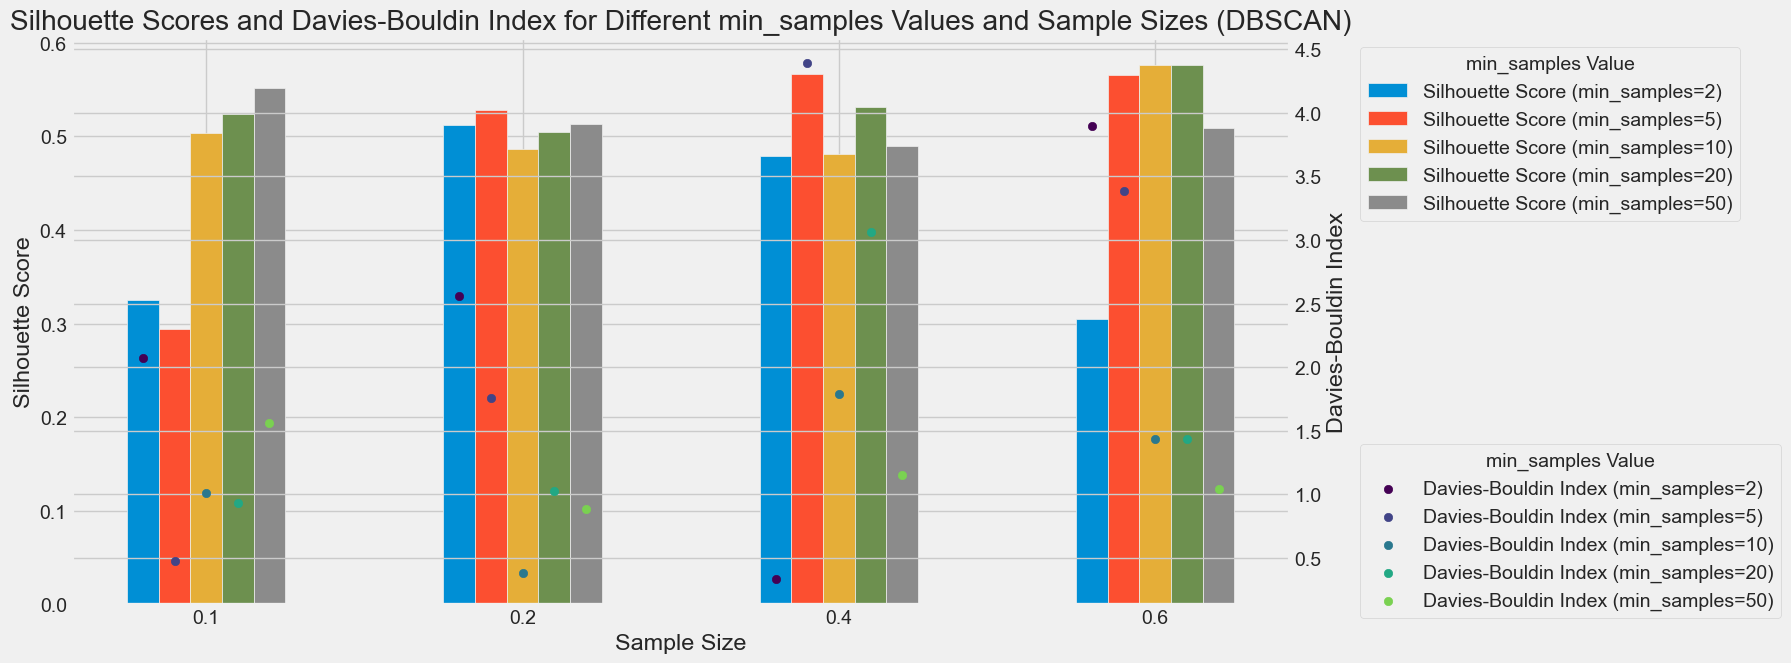

In [66]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time


# Define sample ratios and min_samples values to test
sample_ratios = [0.1, 0.2, 0.4, 0.6]
min_samples_values = [2, 5, 10, 20, 50]  # Different min_samples values to test
epsilon = 0.9  # Fixed epsilon value
silhouette_results = {min_samples: [] for min_samples in min_samples_values}
davies_results = {min_samples: [] for min_samples in min_samples_values}

# Iterate over each min_samples value
for min_samples in min_samples_values:
    # Now iterate over each sample ratio
    for ratio in sample_ratios:
        
        start_time = time.time()
        # Sample a fraction of the data based on the ratio
        features_scaled_sample = scaled_features.sample(frac=ratio)
        # Scale the features of the sample
        # Run DBSCAN clustering on the sampled and scaled features
        dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
        labels = dbscan.fit_predict(features_scaled_sample)
        end_time = time.time()
        training_time = end_time - start_time
        

        # Calculate silhouette score and Davies-Bouldin Index only if there are more than 1 cluster
        if len(set(labels)) > 1:
            silhouette_avg = silhouette_score(features_scaled_sample, labels)
            davies_avg = davies_bouldin_score(features_scaled_sample, labels)
            silhouette_results[min_samples].append(silhouette_avg)
            davies_results[min_samples].append(davies_avg)
        else:
            silhouette_results[min_samples].append(None)  # Only noise points found
            davies_results[min_samples].append(None)

        # Print training time for each case
        print(f"Training Time for min_samples={min_samples}, Sample Ratio={ratio}: {training_time:.2f} seconds")

# Plotting the results
fig, ax = plt.subplots(figsize=(14, 7))

# Create a bar chart with grouped bars for each min_samples value for silhouette scores
bar_width = 0.1
index = np.arange(len(sample_ratios))

for i, (min_samples, scores) in enumerate(silhouette_results.items()):
    # Offset each min_samples's bar by the width
    ax.bar(index + i * bar_width, scores, bar_width, label=f'Silhouette Score (min_samples={min_samples})')

# Plot Davies-Bouldin Index on secondary y-axis
ax2 = ax.twinx()
for i, (min_samples, scores) in enumerate(davies_results.items()):
    ax2.scatter(index + i * bar_width, scores, marker='o', label=f'Davies-Bouldin Index (min_samples={min_samples})', color=plt.cm.viridis(i / len(min_samples_values)))

ax.set_xlabel('Sample Size')
ax.set_ylabel('Silhouette Score')
ax2.set_ylabel('Davies-Bouldin Index')
ax.set_title('Silhouette Scores and Davies-Bouldin Index for Different min_samples Values and Sample Sizes (DBSCAN)')
ax.set_xticks(index + bar_width * (len(min_samples_values) - 1) / 2)
ax.set_xticklabels(sample_ratios)

# Adjust legend position
ax.legend(title='min_samples Value', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title='min_samples Value', bbox_to_anchor=(1.05, 0.3), loc='upper left')

plt.show()


## OPTICS

## Silhouette Index for OPTICS

C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=cityblock, Sample Ratio=0.1: 9.25 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=cityblock, Sample Ratio=0.2: 25.11 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=cityblock, Sample Ratio=0.4: 88.27 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=cityblock, Sample Ratio=0.6: 264.38 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=euclidean, Sample Ratio=0.1: 15.16 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=euclidean, Sample Ratio=0.2: 46.30 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=euclidean, Sample Ratio=0.4: 138.71 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=euclidean, Sample Ratio=0.6: 319.04 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=manhattan, Sample Ratio=0.1: 8.93 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=manhattan, Sample Ratio=0.2: 25.71 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=manhattan, Sample Ratio=0.4: 97.37 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=manhattan, Sample Ratio=0.6: 225.82 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=l1, Sample Ratio=0.1: 9.02 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=l1, Sample Ratio=0.2: 26.05 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=l1, Sample Ratio=0.4: 100.46 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=l1, Sample Ratio=0.6: 221.69 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=l2, Sample Ratio=0.1: 15.83 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=l2, Sample Ratio=0.2: 47.43 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=l2, Sample Ratio=0.4: 136.43 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=l2, Sample Ratio=0.6: 309.86 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=braycurtis, Sample Ratio=0.1: 9.28 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=braycurtis, Sample Ratio=0.2: 27.45 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=braycurtis, Sample Ratio=0.4: 104.41 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for metric=braycurtis, Sample Ratio=0.6: 223.91 seconds


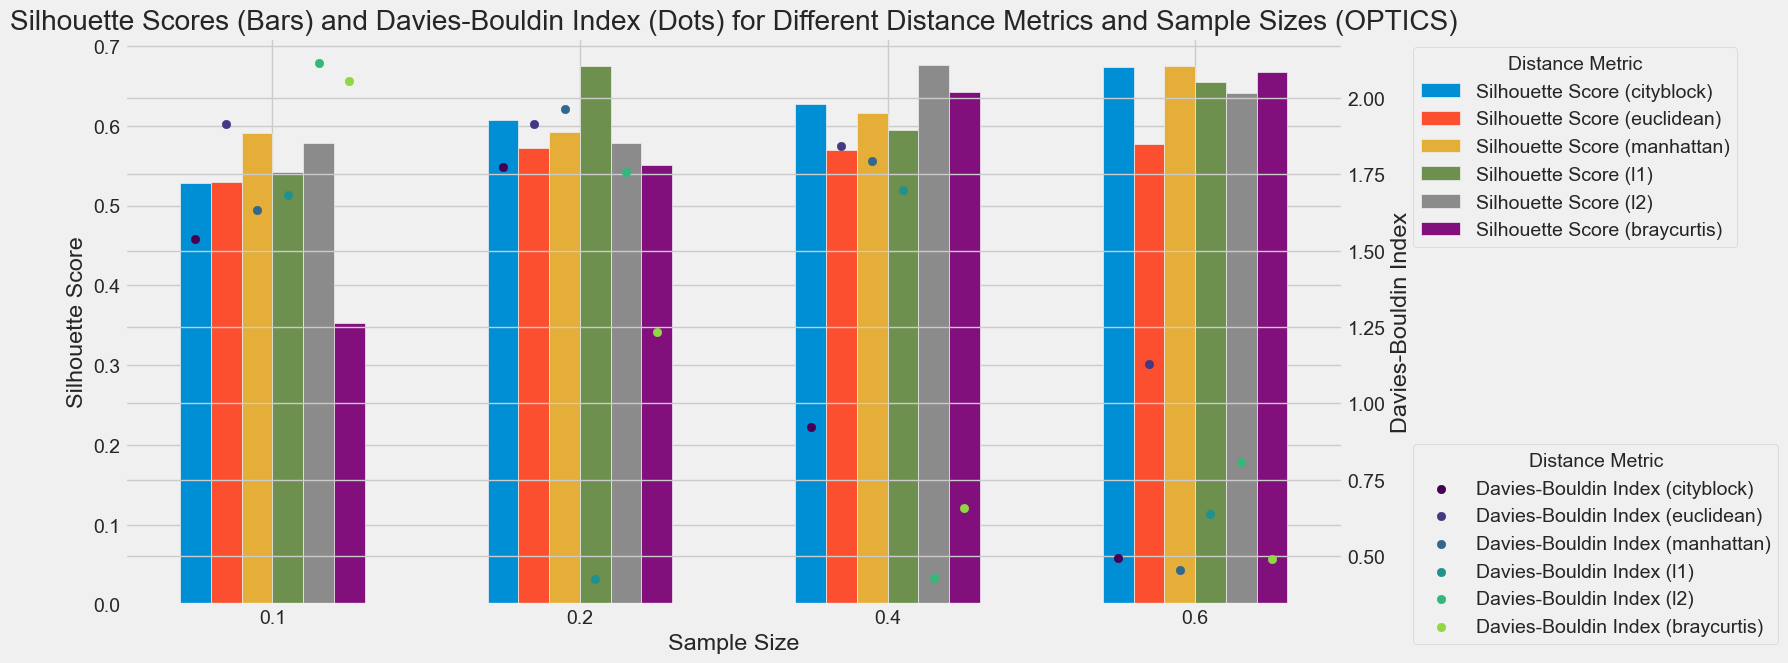

In [70]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time

# Define sample ratios and distance metrics to test
sample_ratios = [0.1, 0.2, 0.4, 0.6]
distance_metrics = ['cityblock', 'euclidean', 'manhattan', 'l1', 'l2', 'braycurtis']
silhouette_results = {metric: [] for metric in distance_metrics}
davies_results = {metric: [] for metric in distance_metrics}
training_times = {metric: [] for metric in distance_metrics}

# Sample the data once for all iterations
# Assuming 'scaled_features' is your DataFrame containing the scaled data

# Iterate over each distance metric
for metric in distance_metrics:
    # Now iterate over each sample ratio
    for ratio in sample_ratios:
        start_time = time.time()
        # Sample a fraction of the data based on the ratio
        features_scaled_sample = scaled_features.sample(frac=ratio)
        
        # Run OPTICS clustering on the sampled and scaled features
        optics = OPTICS(min_samples=2, xi=0.05, min_cluster_size=0.1, metric=metric)
        optics.fit(features_scaled_sample)
        labels = optics.labels_
        end_time = time.time()
        training_time = end_time - start_time
        
        # Calculate silhouette score and Davies-Bouldin Index only if there are more than 1 cluster
        if len(set(labels)) > 1:
            silhouette_avg = silhouette_score(features_scaled_sample, labels)
            davies_avg = davies_bouldin_score(features_scaled_sample, labels)
            silhouette_results[metric].append(silhouette_avg)
            davies_results[metric].append(davies_avg)
            training_times[metric].append(training_time)
        else:
            silhouette_results[metric].append(None)  # Only noise points found
            davies_results[metric].append(None)
            training_times[metric].append(None)

        # Print training time for each case
        print(f"Training Time for metric={metric}, Sample Ratio={ratio}: {training_time:.2f} seconds")

# Plotting the results
fig, ax = plt.subplots(figsize=(14, 7))

# Create bars for silhouette scores for each distance metric
bar_width = 0.1
index = np.arange(len(sample_ratios))
for i, metric in enumerate(distance_metrics):
    ax.bar(index + i * bar_width, silhouette_results[metric], bar_width, label=f'Silhouette Score ({metric})')

# Plot Davies-Bouldin Index on secondary y-axis as dots
ax2 = ax.twinx()
for i, metric in enumerate(distance_metrics):
    ax2.scatter(index + i * bar_width, davies_results[metric], marker='o', label=f'Davies-Bouldin Index ({metric})', color=plt.cm.viridis(i / len(distance_metrics)))

ax.set_xlabel('Sample Size')
ax.set_ylabel('Silhouette Score')
ax2.set_ylabel('Davies-Bouldin Index')
ax.set_title('Silhouette Scores (Bars) and Davies-Bouldin Index (Dots) for Different Distance Metrics and Sample Sizes (OPTICS)')
ax.set_xticks(index + bar_width * (len(distance_metrics) - 1) / 2)
ax.set_xticklabels(sample_ratios)
ax.legend(title='Distance Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title='Distance Metric', bbox_to_anchor=(1.05, 0.3), loc='upper left')

plt.show()


## Optimizing min_samples for OPTICS

C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=2, Sample Ratio=0.1: 4.41 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=2, Sample Ratio=0.2: 11.41 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=2, Sample Ratio=0.4: 33.72 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=2, Sample Ratio=0.6: 75.06 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=5, Sample Ratio=0.1: 7.90 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=5, Sample Ratio=0.2: 19.89 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=5, Sample Ratio=0.4: 60.00 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=5, Sample Ratio=0.6: 125.77 seconds
Training Time for min_samples=10, Sample Ratio=0.1: 8.21 seconds
Training Time for min_samples=10, Sample Ratio=0.2: 20.74 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=10, Sample Ratio=0.4: 56.18 seconds


C:\Users\Manar Anwer\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Training Time for min_samples=10, Sample Ratio=0.6: 61.88 seconds
Training Time for min_samples=20, Sample Ratio=0.1: 4.27 seconds
Training Time for min_samples=20, Sample Ratio=0.2: 10.53 seconds
Training Time for min_samples=20, Sample Ratio=0.4: 29.74 seconds
Training Time for min_samples=20, Sample Ratio=0.6: 71.35 seconds
Training Time for min_samples=50, Sample Ratio=0.1: 4.62 seconds
Training Time for min_samples=50, Sample Ratio=0.2: 18.76 seconds
Training Time for min_samples=50, Sample Ratio=0.4: 47.11 seconds
Training Time for min_samples=50, Sample Ratio=0.6: 55.53 seconds


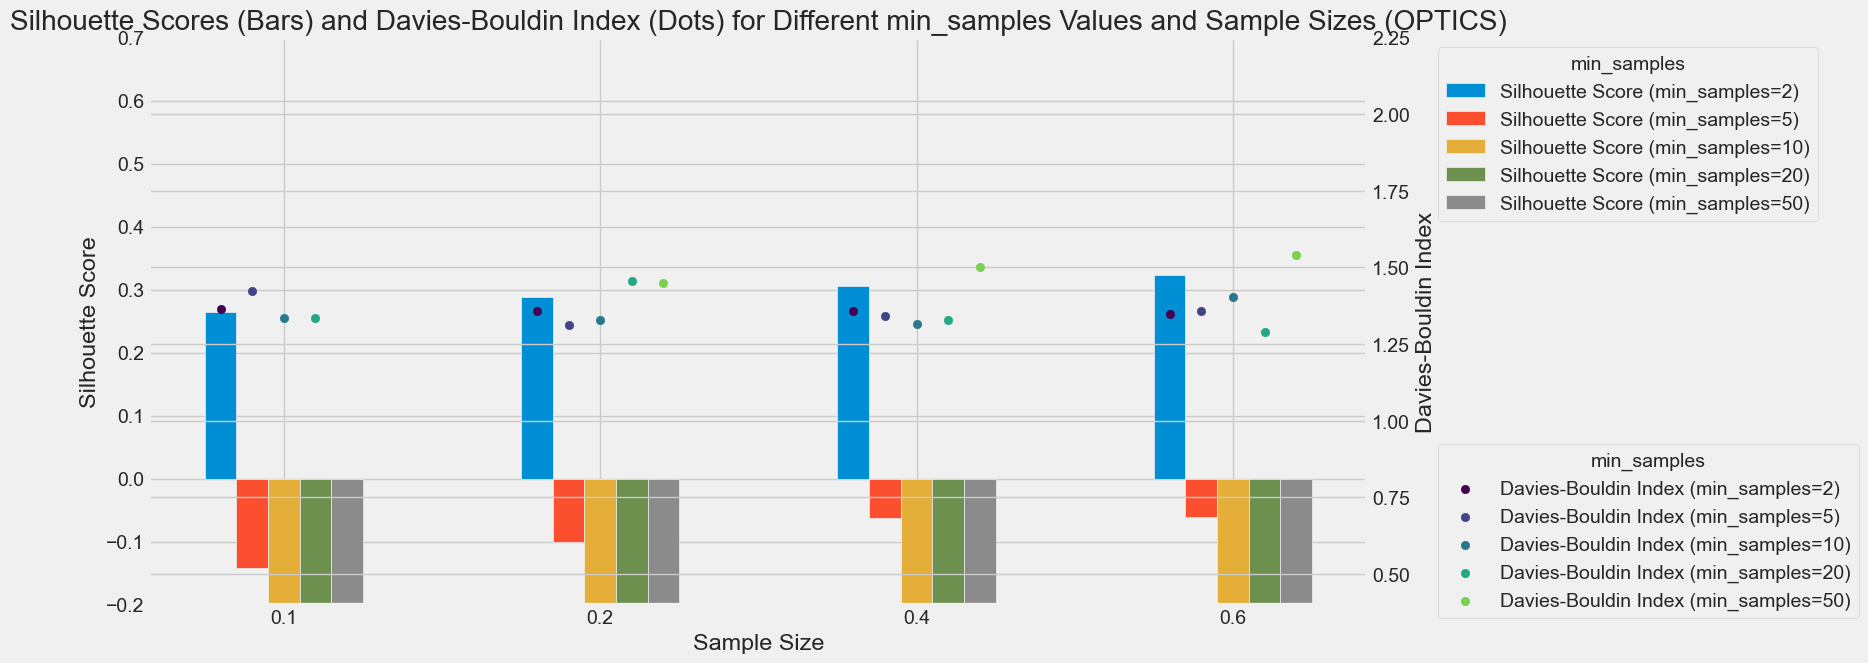

In [93]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import time

# Define sample ratios and distance metrics to test
sample_ratios = [0.1, 0.2, 0.4, 0.6]
min_samples_list = [2, 5, 10, 20, 50]  # Updated min_samples list
silhouette_results = {min_samples: [] for min_samples in min_samples_list}
davies_results = {min_samples: [] for min_samples in min_samples_list}
training_times = {min_samples: [] for min_samples in min_samples_list}

# Sample the data once for all iterations
# Assuming 'scaled_features' is your DataFrame containing the scaled data

# Iterate over each min_samples value
for min_samples in min_samples_list:
    start_time_sampling = time.time()
    # Iterate over each sample ratio
    for ratio in sample_ratios:
        start_time = time.time()
        # Sample a fraction of the data based on the ratio
        features_scaled_sample = scaled_features.sample(frac=ratio)  
        
        # Run OPTICS clustering on the sampled and scaled features
        optics = OPTICS(min_samples=min_samples, metric='euclidean')  # Euclidean metric
        optics.fit(features_scaled_sample)
        labels = optics.labels_
        end_time = time.time()
        training_time = end_time - start_time
        
        # Calculate silhouette score and Davies-Bouldin Index only if there are more than 1 cluster
        if len(set(labels)) > 1:
            silhouette_avg = silhouette_score(features_scaled_sample, labels)
            davies_avg = davies_bouldin_score(features_scaled_sample, labels)
            silhouette_results[min_samples].append(silhouette_avg)
            davies_results[min_samples].append(davies_avg)
            training_times[min_samples].append(training_time)
        else:
            silhouette_results[min_samples].append(None)  # Only noise points found
            davies_results[min_samples].append(None)
            training_times[min_samples].append(None)

        # Print training time for each case
        print(f"Training Time for min_samples={min_samples}, Sample Ratio={ratio}: {training_time:.2f} seconds")

# Plotting the results
fig, ax = plt.subplots(figsize=(14, 7))

# Create bars for silhouette scores for each min_samples value
bar_width = 0.1
index = np.arange(len(sample_ratios))
for i, min_samples in enumerate(min_samples_list):
    ax.bar(index + i * bar_width, silhouette_results[min_samples], bar_width, label=f'Silhouette Score (min_samples={min_samples})')

# Plot Davies-Bouldin Index on secondary y-axis as dots
ax2 = ax.twinx()
for i, min_samples in enumerate(min_samples_list):
    ax2.scatter(index + i * bar_width, davies_results[min_samples], marker='o', label=f'Davies-Bouldin Index (min_samples={min_samples})', color=plt.cm.viridis(i / len(min_samples_list)))

ax.set_xlabel('Sample Size')
ax.set_ylabel('Silhouette Score')
ax2.set_ylabel('Davies-Bouldin Index')
ax.set_title('Silhouette Scores (Bars) and Davies-Bouldin Index (Dots) for Different min_samples Values and Sample Sizes (OPTICS)')
ax.set_xticks(index + bar_width * (len(min_samples_list) - 1) / 2)
ax.set_xticklabels(sample_ratios)
ax.legend(title='min_samples', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend(title='min_samples', bbox_to_anchor=(1.05, 0.3), loc='upper left')

# Set y-axis limits
ax.set_ylim(-0.2, 0.7)
ax2.set_ylim(0.4, 2.25)

plt.show()
